In [2]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy.linalg as npl
from scipy.optimize import minimize
import math as math
from itertools import combinations
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

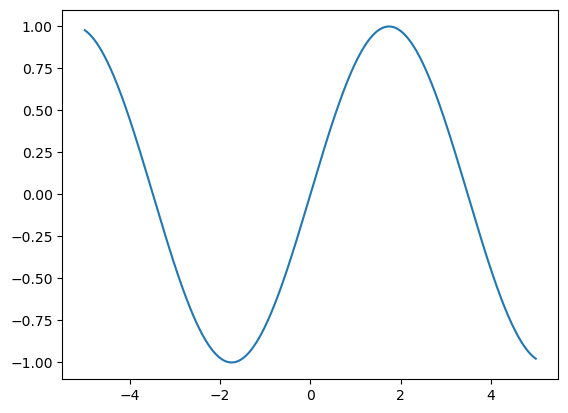

In [3]:
# The true function 
def f(x):
    return np.sin(0.9*x)

x = np.linspace(-5,5,1000)

plt.plot(x,f(x))
plt.show()

In [4]:
def Kernel(a,b,l,var):
    dist_ab = (a - b.T)**2
    return var*np.exp(-1/(2*l**2)*(dist_ab))

# Black Box

In [72]:
#xtrain = np.array([[-5., -3.88888889,-2.77777778,-0.55555556,0.55555556,2.77777778  ,3.88888889,5.]]).reshape(-1,1)
xtrain = np.linspace(-5,5,10).reshape(-1,1)
xtest = np.linspace(-5,5,100).reshape(-1,1)

In [74]:
noise = 0.01   ## Noise added to true training points
bounds = [(1e-2, 1e2)]   ## These are bounds in for which minimisation can occur
initl= 1  ## This is the initial parameter for length
initvar = 1

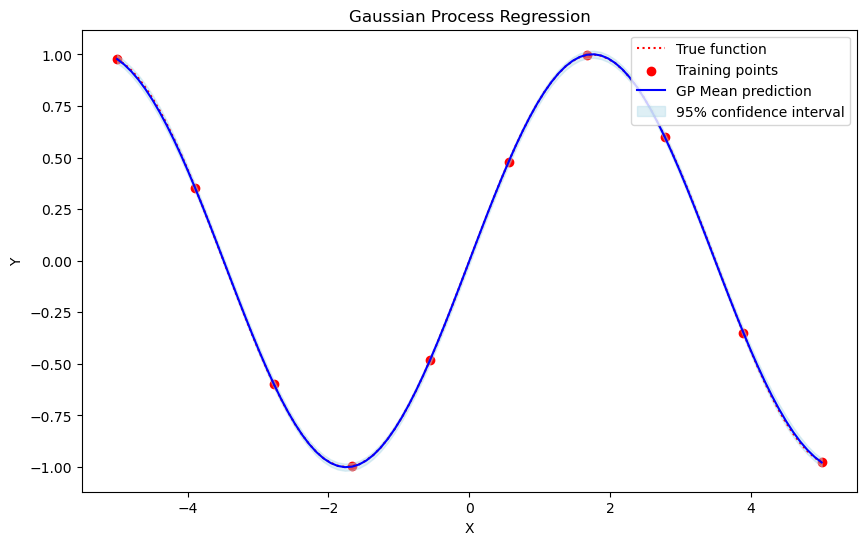

Optimal length scale parameter: 2.3852011399731716
Optimal variance scale parameter: 1.4122232350569128


In [76]:
kernel = C(constant_value = initvar,constant_value_bounds = bounds)* RBF(length_scale= initl, length_scale_bounds= bounds)
gp = GaussianProcessRegressor(kernel=kernel,alpha = noise**2, n_restarts_optimizer=10)
gp.fit(xtrain, f(xtrain))
y_pred, sigma = gp.predict(xtest, return_std=True)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(xtest, f(xtest), 'r:', label="True function")
plt.scatter(xtrain, f(xtrain), c='r', label="Training points")
plt.plot(xtest, y_pred, 'b-', label="GP Mean prediction")
plt.fill_between(xtest.ravel(), y_pred - 2 * sigma, y_pred + 2 * sigma, color="lightblue", alpha=0.4, label="95% confidence interval")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Gaussian Process Regression")
plt.legend()
plt.show()

optimal_length_scale = gp.kernel_.k2.length_scale
optimal_var_scale = gp.kernel_.k1.constant_value
print(f"Optimal length scale parameter: {optimal_length_scale}")
print(f"Optimal variance scale parameter: {optimal_var_scale}")

# Marginal Likelihood

In [79]:
def marglike(param,X,Y,noise):
  l = param[0]
  var = param[1]
  n = len(X)
  ## adding in noise to match the black box
  ## Had my identity matrix defined below wrong for ages
  k = Kernel(X,X,l,var) + (noise)**2*np.eye(n,n)
  inverse = np.linalg.inv(k)
  # Potential More stable way of handling determinants below
  ##L = np.linalg.cholesky(k)
  ##logdet_k = 2 * np.sum(np.log(np.diag(L)))
  ml = (1/2)*(Y.T@inverse@Y) + 1/2* np.linalg.slogdet(k)[1]
  return ml[0][0]
    
re = minimize(marglike,[initl,initvar],args=(xtrain,f(xtrain),noise),method="L-BFGS-B",bounds = bounds,options = {'disp':True})
l = re.x[0]
var = re.x[1]
print(f"Optimal length scale parameter: {l}")
print(f"Optimal variance scale parameter: {var}")

Optimal length scale parameter: 2.385200890825195
Optimal variance scale parameter: 1.4122256312022667


# Trying Gradient Descent Unsuccessfully

In [763]:
def marglike(l,X,Y,noise):
  n = len(X)
  ## adding in noise to match the black box
  ## Had my identity matrix defined below wrong for ages
  k = Kernel(X,X,l,0) + (noise)**2*np.eye(n,n)
  inverse = np.linalg.inv(k)
  # Potential More stable way of handling determinants below
  ##L = np.linalg.cholesky(k)
  ##logdet_k = 2 * np.sum(np.log(np.diag(L)))
  ml = (1/2)*(Y.T@inverse@Y) + 1/2* np.linalg.slogdet(k)[1]
  return ml[0][0]


def grad_l_loglike(l,a,b,y):
    dist = (a - b.T)**2
    kernel = np.exp(-1/(2*l**2)*(dist))
    kernelinv = npl.inv(kernel)
    alpha = kernelinv@y
    dkerneldl = dist**2/(l**3)*kernel
    dldlog = 0.5*np.trace((alpha@alpha.T-kernelinv)@dkerneldl)
    return dldlog

In [773]:
## Trying to use Gradient Descent. Unsuccessfully

l = initl
#print(grad_l_loglike(l,xtrain,xtrain,f(xtrain)))
N = 100
tol = 1e-12
for i in range(N):
## FIXME, Figure out a way to get an optimal alpha
## Issue, Needs look could be nice extra touch to add over Christmas
## Christmas Work
    lnew = l -0.001*grad_l_loglike(l,xtrain,xtrain,f(xtrain))
    if (np.abs(marglike(lnew,xtrain,f(xtrain),noise)-marglike(l,xtrain,f(xtrain),noise))<tol):
        print(f"The number of iterations {i}")
        break
    l = lnew
print(f"Optimal length scale parameter: {l}")

The number of iterations 0
Optimal length scale parameter: 1


# Minimising L2 norm

In [81]:
## This returns the summed distance when all points are removed. 

def Kernel(a,b,sigma,l):
    # we take len(a) = len(b)
    n= len(a)
    q= len(b)
    sqrdist = np.zeros((n,q))
    for j in range(0,n):
        for i in range(0,q):
           sqrdist[j,i] = (a[j]-b[i])**2 
    return sigma*np.exp(-1/(2*l**2)*(sqrdist))

def GPR(xtest,xtrain,Nobs,sigma,l):
    y = f(xtrain)
    A = Kernel(xtrain,xtrain,sigma,l)
    Ainv =np.linalg.inv(A)
    fstar = Kernel(xtest,xtrain,sigma,l)@Ainv@y
    varf = Kernel(xtest,xtest,sigma,l)-Kernel(xtest,xtrain,sigma,l)@Ainv@Kernel(xtrain,xtest,sigma,l)
    varfxtest = varf.diagonal()
    std=np.sqrt(np.abs(varfxtest))
    return fstar,std


def L2norm(param,Nobs,Ncheck):
    l = param
    sigma = 1 ### variance
    n=10
    Ntrain = Nobs-Ncheck
    # Number of observations - check points
    Ntest = int((Nobs-1)*n+1)
    xtest = []
    xinit= np.linspace(-5,5,Nobs)
    j=0
    # This is to make sure xtest contains the exact x training values
    while(j<Nobs-1):
        if (j==Nobs-2):
            xtest.append(np.linspace(xinit[j],xinit[j+1],int((Ntest-1)/5)+1,endpoint=True))
        else:
            xtest.append(np.linspace(xinit[j],xinit[j+1],int((Ntest-1)/5),endpoint=False))
        j+=1
    xtest = np.concatenate(xtest)
    js = np.arange(1, Nobs - 1, dtype=int)
    pairs = np.array(list(combinations(js, Ncheck)))
    N = len(pairs)
    count = 0
    dif=0
    while(count<N):
        xcheck = []
        i = pairs[count,0]
        j = pairs[count,1]
        xcheck.append(xinit[i])
        xcheck.append(xinit[j])
        num = np.array([np.argwhere(xtest == xcheck[0]).item(),np.argwhere(xtest == xcheck[1]).item()])
        xtrain = np.delete(xinit,[i,j])
        mean,std = GPR(xtest,xtrain,Ntrain,sigma,l)
        dif += 0.5*np.sqrt((mean[num[0]]-f(xcheck[0]))**2+(mean[num[1]]-f(xcheck[1]))**2)
        count+=1
    return dif
## FIXME  1/Ncheck replace 0.5 

In [83]:
## We minimize the summed distance 
initial_param = 1.0 

Nobs = 10   
Ncheck = 2 

result = minimize(L2norm, initial_param, args=(Nobs, Ncheck), method="L-BFGS-B")
l = result.x[0]
print(f"L for minimised L2 norm = {l}")
print(f"Resulting L2 norm average = {L2norm(l,Nobs,Ncheck)/28}\n")
## divide by 28 the number of pairs

L for minimised L2 norm = 1.8619686338887704
Resulting L2 norm average = 0.011171941273921038

